In [ ]:
# Importing python libraries

import pandas as pd               # For Dataframe operations
import numpy as np                # For array calcualtion
import matplotlib.pyplot as plt   # For plotting purpose
import math                       # for flooring floats
import os                         # For storing images
from PIL import Image             # For reading CWT images

In [ ]:
# Mounting gdrive to read dataset

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive




*   Paste "**sample_AP_train.csv**" in google drive
*   Copy path of the folder "**sample_AP_train.csv**" and paste to read dataset



In [ ]:
# Reading the dataset into pandas dataframe

df_data = pd.read_csv("/content/drive/path_to_data.csv", index_col=0)

df_data.head(5)         # Printing first 5 values of dataset

,Time (ms),Membrane Potential (mV)
0,0.00,-66.481339
1,0.02,-66.856187
2,0.04,-66.637526
3,0.06,-66.731238
4,0.08,-67.012373


Few Observations about the dataset:

1.   As the sampling frequency is 50KHz. We can see that each sample is acquired at a gap of 0.02 ms.
2.   The whole data is recorded for a time-span of 1.2 s (approx).





In [ ]:
print("Shape of data set:", df_data.shape)

Shape of data set: (59750, 2)


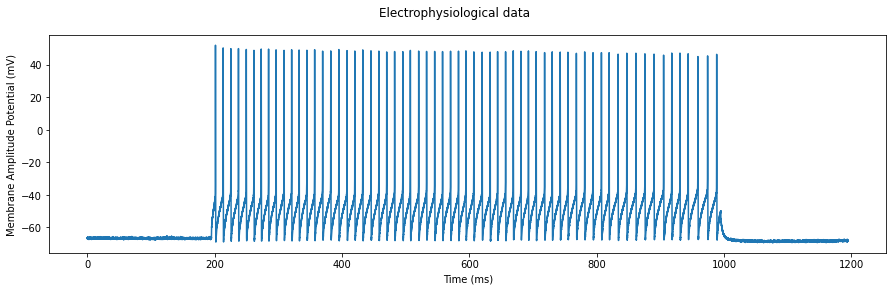

In [ ]:
# Plot of the overall dataset

fig,ax = plt.subplots(figsize=(15,4))
plt.plot(df_data["Time (ms)"], df_data["Membrane Potential (mV)"])
plt.ylabel("Membrane Amplitude Potential (mV)")
plt.xlabel("Time (ms)")
plt.suptitle("Electrophysiological data")
plt.show()

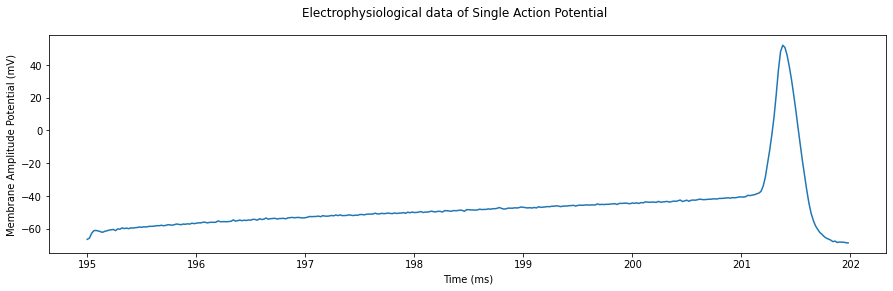

In [ ]:
# Plot of the overall dataset

a=9750
b=10100

fig,ax = plt.subplots(figsize=(15,4))
plt.plot(df_data["Time (ms)"][a:b], df_data["Membrane Potential (mV)"][a:b])
plt.ylabel("Membrane Amplitude Potential (mV)")
plt.xlabel("Time (ms)")
plt.suptitle("Electrophysiological data of Single Action Potential")
plt.show()

Observation:

1. Depolarizing step is started from 200ms and ended at 1000ms.

2. We can see that the a single action Potential rises from -65mV and reaches a peak of 45mV(approx) and comes bact to -65mV

3. This cycle took 600 samples of reading i.e. 350*0.02ms = 7 ms

# **Method 1** to detect Action Potential:

 1. Action Potential is an event which is triggered when the membrane potential reaches the threshold value. Once reached, it rise to a significant value(often 40mV-50mV) with a spike and end up coming back to the resting potential of -65mV.

 2. We can detect the number of Action Potential events automatically if we can check how many times a horizontal line crosses (at a level of 0-20mv value) the membrane Potential curve. 

 3. Once calculated the number of crossing intercepts, we can divide it by 2 (divided by 2, since one intercept is for rising and one for falling) to get the correct number of elicit of action potentials in the neuron.

 4. Since, the intercept can not be calculated easily as the membrane potential data is not continuous. We will need to use interpolation technique to generate more samples around in the time-series data.

 5. Once generated, we can simply check for interceptions.

In [ ]:
def calculate_interception(series, cross=0, direction='cross'):
    """
    Given a Series(membrane potential time-series data) returns all the 
    index values where the data values equal the 'cross' value. It will \
    be typically a value in the range [0-20mV]

    Direction can be 'rising' (for rising edge), 'falling' (for only falling 
    edge), or 'cross' for both edges
    """
    # Find if values are above or bellow yvalue crossing:
    above=series.values > cross
    print("above",above)
    below=np.logical_not(above)
    print("below", below)
    left_shifted_above = above[1:]
    print("left_shifted_above",left_shifted_above)
    left_shifted_below = below[1:]
    print("left_shifted_below",left_shifted_below)
    x_crossings = []
    # Find indexes on left side of crossing point
    if direction == 'rising':
        idxs = (left_shifted_above & below[0:-1]).nonzero()[0]       
    elif direction == 'falling':
        idxs = (left_shifted_below & above[0:-1]).nonzero()[0]
    else:
        rising = left_shifted_above & below[0:-1]
        falling = left_shifted_below & above[0:-1]
        idxs = (rising | falling).nonzero()[0]

    # Calculate x crossings with interpolation using formula for a line:
    x1 = series.index.values[idxs]
    print("indexes obtained from interceptions",idxs)
    print("x1",x1)
    x2 = series.index.values[idxs+1]
    print("x2",x2)
    y1 = series.values[idxs]
    print("y1",y1)
    y2 = series.values[idxs+1]
    print("y2",y2)
    x_crossings = (cross-y1)*(x2-x1)/(y2-y1) + x1

    return x_crossings

In [ ]:
# Calculation of number of elicit of Action Potential in total.

elicit_index = calculate_interception(df_data["Membrane Potential (mV)"], cross=20, direction='rising')
num_elicits  = len(elicit_index)

print("Number of elicit Action Potentials:", num_elicits)

above [False False False ... False False False]
below [ True  True  True ...  True  True  True]
left_shifted_above [False False False ... False False False]
left_shifted_below [ True  True  True ...  True  True  True]
indexes obtained from interceptions [10065 10668 11273 11870 12485 13088 13658 14235 14823 15449 16047 16632
 17244 17853 18481 19119 19753 20395 21007 21631 22275 22896 23512 24132
 24778 25367 26022 26642 27277 27896 28524 29148 29729 30353 31006 31632
 32219 32846 33449 34054 34639 35246 35909 36508 37135 37739 38404 39057
 39712 40371 40975 41679 42363 43078 43787 44502 45254 45895 46538 47180
 47948 48710 49422]
x1 [10065 10668 11273 11870 12485 13088 13658 14235 14823 15449 16047 16632
 17244 17853 18481 19119 19753 20395 21007 21631 22275 22896 23512 24132
 24778 25367 26022 26642 27277 27896 28524 29148 29729 30353 31006 31632
 32219 32846 33449 34054 34639 35246 35909 36508 37135 37739 38404 39057
 39712 40371 40975 41679 42363 43078 43787 44502 45254 45895 46538

In [ ]:
### time-stamp at which membrame potential is crossing 0mV amplitude level.

elicit_index

array([10065.87218186, 10668.49346577, 11273.31683648, 11870.92209635,
       12485.31676781, 13088.0393353 , 13658.53131233, 14235.2351535 ,
       14823.07148775, 15449.74102874, 16047.51239221, 16632.04201117,
       17244.58164785, 17853.74302095, 18481.98447704, 19119.04308587,
       19753.74662139, 20395.91104128, 21007.90795915, 21631.31947387,
       22275.35017209, 22896.27208574, 23512.02365601, 24132.92304959,
       24778.61813717, 25367.68594571, 26022.55110656, 26642.74830662,
       27277.43499298, 27896.99173078, 28524.83576105, 29148.60210187,
       29729.76067671, 30353.68058652, 31006.56672857, 31632.32199747,
       32219.14841083, 32846.58339654, 33449.77268316, 34054.2872977 ,
       34639.71719936, 35246.68756351, 35909.3370758 , 36508.37651964,
       37135.55983201, 37739.46467335, 38404.35432921, 39057.53205433,
       39712.60755296, 40371.4017024 , 40975.75006204, 41679.29983833,
       42363.26108336, 43078.80976847, 43787.02706151, 44502.19645042,
      

In [ ]:
# Function to plot the action Potential

def plot_action_potential(elecit_number):

  """
  Takes input the nth elicit Action Potential and
  plots the membrane Potential vs Time plot.     
  """

  a=math.floor(elecit_number)-315  # manually caliberated. plot from 315 samples back
  b=a+350                    # manually caliberated. plot for next 350 samples. 
                                   # We saw earlier each action potential take 350 samples normally.

  fig,ax = plt.subplots(figsize=(15,4))
  plt.plot(df_data["Time (ms)"][a:b], df_data["Membrane Potential (mV)"][a:b])
  plt.ylabel("Membrane Amplitude Potential (mV)")
  plt.xlabel("Time (ms)")
  plt.suptitle("Electrophysiological data of Single Action Potential")
  plt.show()


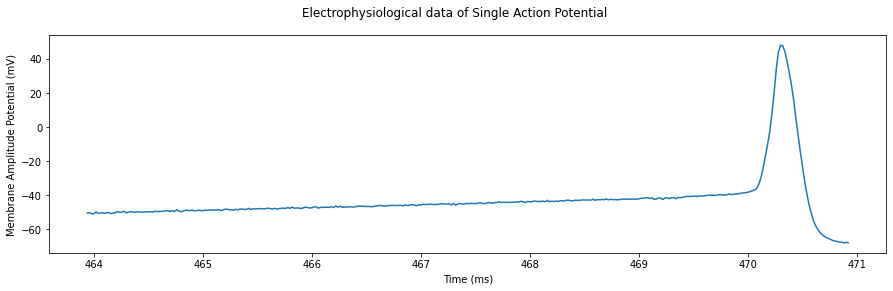

In [ ]:
plot_action_potential(elicit_index[22])     # Plot the 22nd Action Potential.